# Large-Domain Animation

This Notebook generates large-domain prediction plots and animations.  It is principally designed for a CONUS-scale run prepared for AGU24.  It is assumed that predictions are already available.

The run in question involves ~100k points for ~20 years.  At daily resolution, this is a few tens of gigabytes of data, which is obviously unworkable.  Instead, we're going to use the 7-day mean from 2018-2022 (arbitrarily).  So the first thing we have to do is reorganize the data, incrementally.

Then the plot.  ~100k pour point temperatures is, if square and evenly distributed, about 300x300, which should be visible at high resolution, though it's going to look like more of a surface than a river network in a lot of places.  Hopefully the images will compress reasonably well.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np
import geopandas as gpd
outpath = "/scratch/dphilippus/pyproc/CONUS2021.csv"

# Reorganize Data

First things first: incrementally grab lat, lon, date, temperature for each river for 2018-2022 only, aggregate to weekly, and put that in one big file.  While we're at it, we'll filter for at least a year of coverage, to avoid clutter.

In [2]:
import os
inpath = "/scratch/dphilippus/pyproc/CONUS12/"

In [ ]:
inputs = os.listdir(inpath)
print(len(inputs))
append = False
counter = 0
for inp in inputs:
    dat = pd.read_csv(inpath + inp, dtype={"id": "str"}, parse_dates=["date"])
    dat["week"] = dat["date"].dt.isocalendar().week
    dat["year"] = dat["date"].dt.year
    if not "area" in dat.columns:
        dat["area"] = 1e8  # default: small HUC12, ~10km x 10km
    dat = dat[(dat["date"] >= "2018-01-01") & (dat["date"] < "2023-01-01")][
        ["date", "year", "week", "lat", "lon", "area", "temp.mod"]].dropna().\
        groupby(["year", "week"]).agg({"date": "first", "lat": "first", "lon": "first", "area": "first", "temp.mod": "mean"})
    if len(dat) > 50:
        dat.to_csv(outpath, header=not append, mode='a' if append else 'w')
        append = True
    if counter % 200 == 0:
        print("|", end="")
    if counter % 2000 == 0:
        print(counter, end="")
    counter += 1

23355
|0

# Load Data and Make Individual Plots

US states shapefile: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [4]:
data = pd.read_csv(outpath, parse_dates=["date"])
data = data[(data["temp.mod"] > -1) & (data["temp.mod"] < 40)]
data["date"] = data["date"].dt.normalize()
data

,year,week,date,lat,lon,area,temp.mod
0,2018,1,2018-01-01,41.132054,-103.262822,92710000.0,0.879191
1,2018,2,2018-01-08,41.132054,-103.262822,92710000.0,1.429075
2,2018,3,2018-01-15,41.132054,-103.262822,92710000.0,0.797702
3,2018,4,2018-01-22,41.132054,-103.262822,92710000.0,0.943508
4,2018,5,2018-01-29,41.132054,-103.262822,92710000.0,2.113864
...,...,...,...,...,...,...,...
2220183,2022,48,2022-11-28,36.415789,-99.807017,84210000.0,10.011584
2220184,2022,49,2022-12-05,36.415789,-99.807017,84210000.0,11.184945
2220185,2022,50,2022-12-12,36.415789,-99.807017,84210000.0,8.161798
2220186,2022,51,2022-12-19,36.415789,-99.807017,84210000.0,5.050585


In [5]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]  # lower 48

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


/tmp/ipykernel_307244/2621583125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jul["rel_area"] = jul["area"] / jul["area"].max() * 8


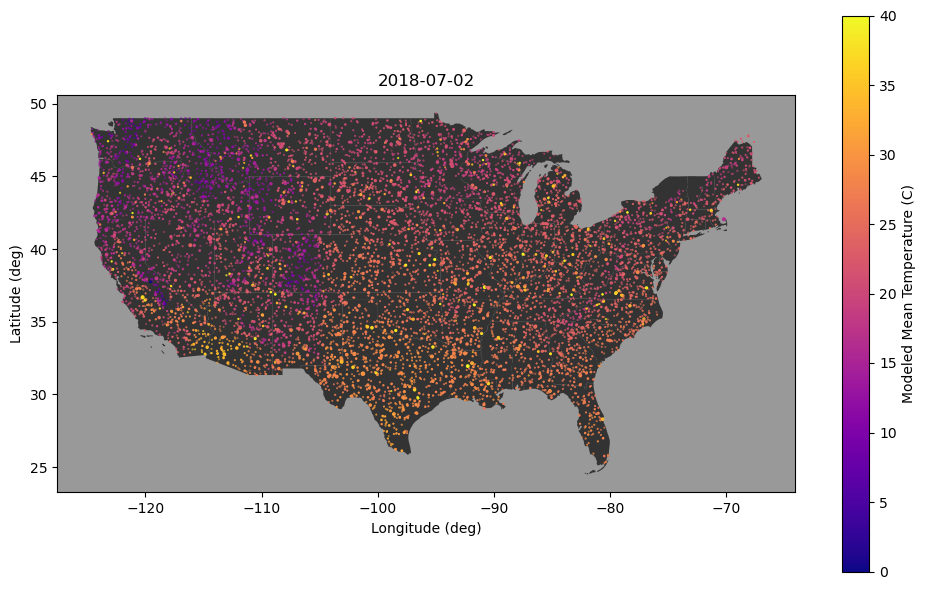

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(facecolor="#999")
jul = data[data["date"] == "2018-07-02"]
jul["rel_area"] = jul["area"] / jul["area"].max() * 8
states.plot(ax=ax, color="#333")
jul.plot.scatter(x="lon", y="lat", c="temp.mod", title="2021-07-01", ax=ax, colormap="plasma", s="rel_area", vmin=0, vmax=40)
cb = ax.collections[1].colorbar
cb.set_label("Modeled Mean Temperature (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
_ = ax.set_title("2018-07-02")
plt.tight_layout()

# Animate It!

MovieWriter ffmpeg unavailable; using Pillow instead.


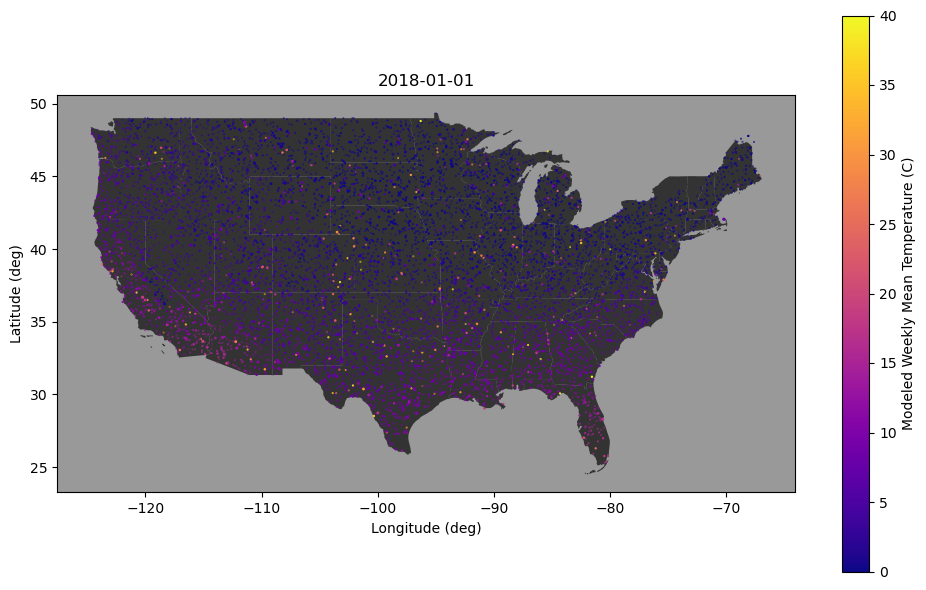

In [7]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(facecolor="#999")
dates = np.array(data["date"].unique(), dtype='datetime64[D]')
data["rel_area"] = data["area"] / data["area"].max() * 4
def animate(i):
    date = dates[i]
    fig.clear()
    ax = plt.axes(facecolor="#999")
    states.plot(ax=ax, color="#333")
    data[data["date"] == date].plot.scatter(x="lon", y="lat", c="temp.mod", title=str(date), ax=ax, colormap="plasma", s="rel_area", vmin=0, vmax=40)
    ax.collections[1].colorbar.set_label("Modeled Weekly Mean Temperature (C)")
    ax.set_xlabel("Longitude (deg)")
    ax.set_ylabel("Latitude (deg)")
    plt.tight_layout()

a = anim.FuncAnimation(fig, animate, interval=150, frames=range(len(dates)))
a.save("conus18to22.gif")